In [1]:
!pip install monai nibabel scikit-learn matplotlib joblib



In [3]:
from monai.transforms import Compose, LoadImage, EnsureChannelFirst, Resize, ScaleIntensity
from tensorflow.keras.models import load_model
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import numpy as np
import joblib


In [141]:
mri_file = "im4.nii"  # Change this to your actual file name

transform = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Resize(spatial_size=(128, 128, 64)),
    ScaleIntensity()
])

image = transform(mri_file)
image_np = image.unsqueeze(0).numpy()  # shape: (1, 1, 128, 128, 64)


In [143]:
unet_model = load_model("GP-4_model.h5")
# Transpose (batch, channel, H, W, D) → (batch, H, W, D, channel)
image_input = np.transpose(image_np, (0, 2, 3, 4, 1))  # Now shape: (1, 128, 128, 64, 1)

# Predict
mask_pred = unet_model.predict(image_input)[0, ..., 0]
mask_bin = (mask_pred > 0.5).astype(np.uint8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [144]:
def extract_features(image_np, mask_bin):
    # Collapse 3D mask to 2D slices and pick the largest
    max_area = 0
    best_slice = None
    best_index = None

    for i in range(mask_bin.shape[2]):  # loop over depth
        slice_mask = mask_bin[:, :, i]
        props = regionprops(slice_mask.astype(np.uint8), intensity_image=image_np[0, 0, :, :, i])
        if props:
            if props[0].area > max_area:
                max_area = props[0].area
                best_slice = props[0]
                best_index = i

    if best_slice is None:
        return None

    return [
        np.sum(mask_bin),                      # 3D volume
        best_slice.mean_intensity,            # 2D mean intensity
        best_slice.eccentricity,              # shape
        best_slice.solidity,                  # shape
        best_index                            # store the slice index used
    ]


In [145]:
features = extract_features(image_np, mask_bin)

if features is None:
    print("❌ No tumor detected.")
else:
    slice_idx = features[-1]  # middle slice replaced by the one with largest tumor
    features = features[:-1]  # remove slice index from features


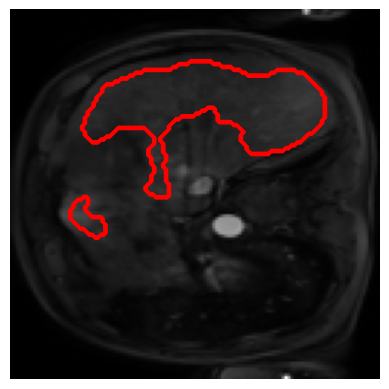

In [146]:
plt.imshow(image_np[0, 0, :, :, slice_idx], cmap="gray")
plt.contour(mask_bin[:, :, slice_idx], colors='r')
plt.axis("off")
plt.show()


In [151]:
loaded = joblib.load("svm_model_with_scaler.joblib")
svm_model = loaded["model"]
scaler = loaded["scaler"]


In [153]:
single_feature = [[features[0]]]  # Tumor volume
features_scaled = scaler.transform(single_feature)
prediction = svm_model.predict(features_scaled)[0]
tumor_type = "Malignant" if prediction == 1 else "Benign"


In [155]:
print("Scaler was trained on:", loaded["scaler"].n_features_in_, "feature(s)")


Scaler was trained on: 1 feature(s)


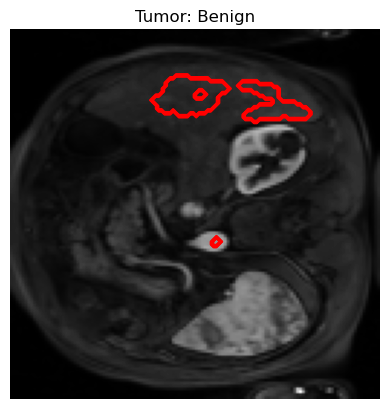

In [157]:
slice_idx = mask_bin.shape[2] // 2
plt.imshow(image_np[0, 0, :, :, slice_idx], cmap="gray")
plt.contour(mask_bin[:, :, slice_idx], colors='r')
plt.title(f"Tumor: {tumor_type}")
plt.axis("off")
plt.show()


In [139]:
print("📋 Tumor Detection Report")
print(f"Tumor Type: {tumor_type}")
print(f"Tumor Volume (voxels): {features[0]}")
print(f"Mean Intensity: {features[1]:.2f}")
print(f"Eccentricity: {features[2]:.2f}")
print(f"Solidity: {features[3]:.2f}")


📋 Tumor Detection Report
Tumor Type: Benign
Tumor Volume (voxels): 81243
Mean Intensity: 0.38
Eccentricity: 0.84
Solidity: 0.83
